In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

Threshold function:

In [2]:
def threshold_image(im,th):
  threshold_im = np.zeros(im.shape)
  threshold_im[im>th] = 1
  return threshold_im

Ostu’s function:

In [3]:
def compute_otsu_criteria(im, th):
  threshold_im = threshold_image(im, th)
  nb_pixels = im.size
  nb_pixels1 = np.count_nonzero(threshold_im)
  weight1 = nb_pixels1/nb_pixels
  weight0 = 1 - weight1
  if weight1 == 0 or weight0 == 0:
    return np.inf
  val_pixels1 = im[threshold_im==1]
  val_pixels0 = im[threshold_im==0]
  var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0
  var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
  return weight0 * var0 + weight1 * var1

The below function loops through all possible K values and selects the best k value based on above function.

In [4]:
def find_best_threshold(im):
  threshold_range = range(np.max(im) + 1)
  criterias = [compute_otsu_criteria(im, th) for th in threshold_range]
  best_threshold = threshold_range[np.argmin(criterias)]
  return best_threshold

Usage

In [5]:
path_image = r'./image/image_9.jpeg'
im = np.asarray(Image.open(path_image).convert('L'))
im_otsu = threshold_image(im, find_best_threshold(im))

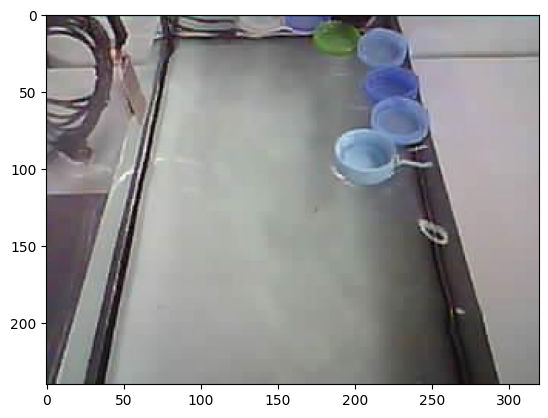

In [6]:
import matplotlib.image as mpimg
image = mpimg.imread(path_image)
plt.imshow(image)
plt.show()

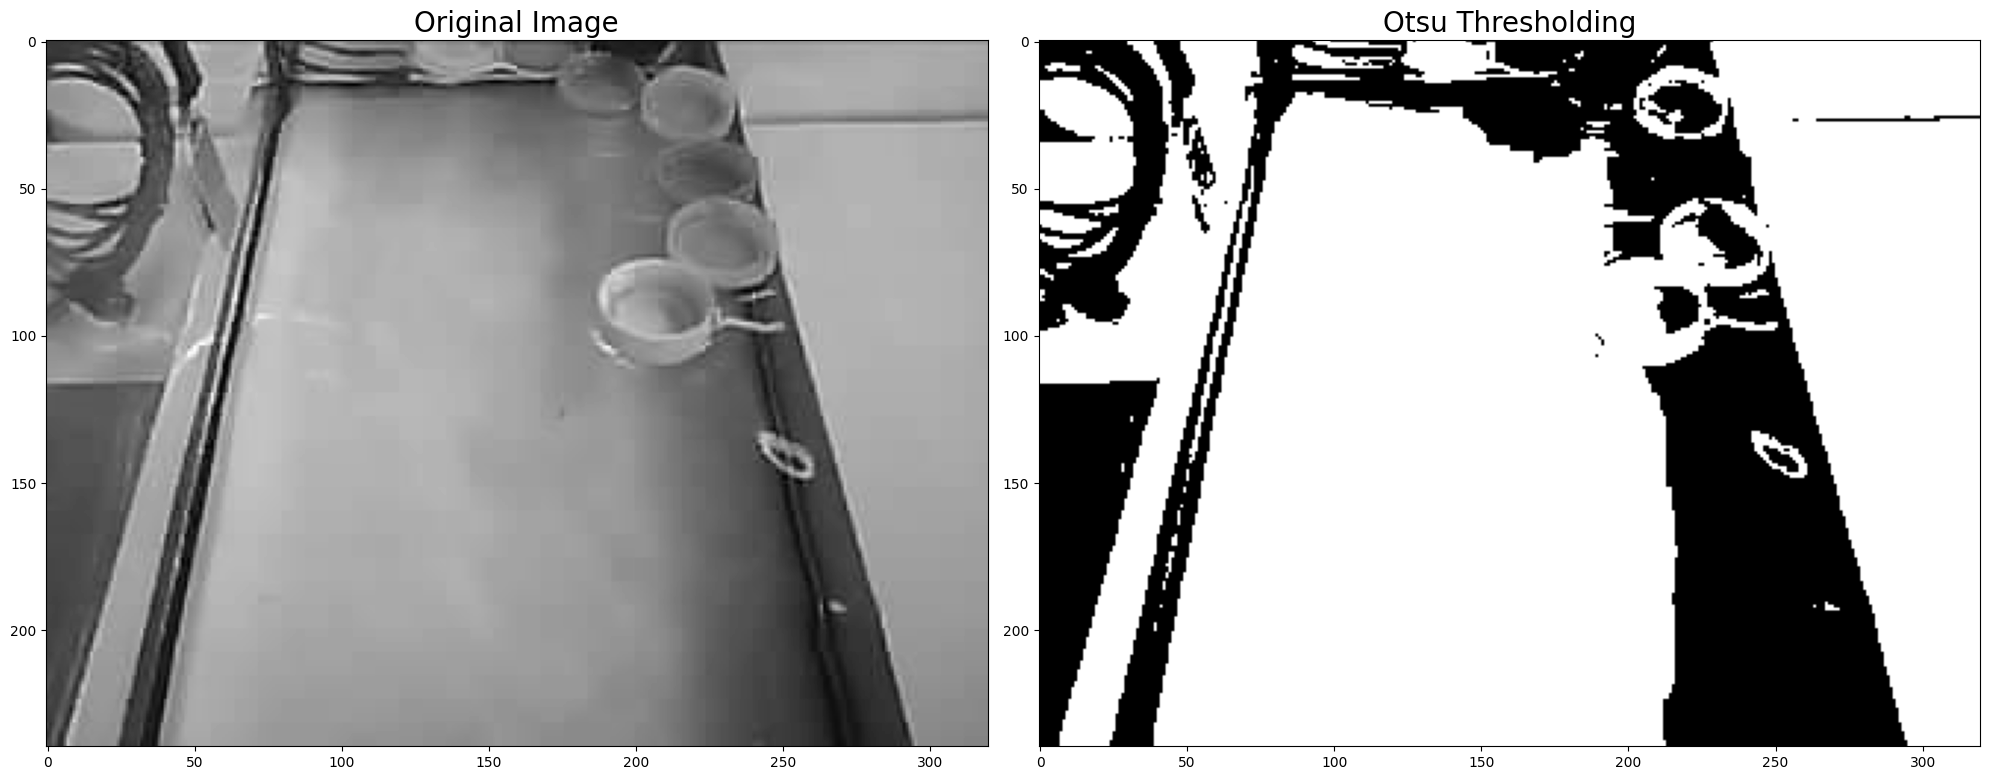

In [7]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Original Image', fontsize=20)
plt.imshow(im, cmap='gray')
plt.subplot(1,2,2)
plt.title('Otsu Thresholding', fontsize=20)
plt.imshow(im_otsu, cmap='gray')
plt.tight_layout()

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_and_segment(image_path):
    # Load the image in grayscale
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

    # Apply Otsu's thresholding
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Display the results
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(gray, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Enhanced + Blurred")
    plt.imshow(blurred, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Otsu + Cleaned")
    plt.imshow(cleaned, cmap="gray")

    plt.tight_layout()
    plt.show()

    return cleaned  # Binary image after optimization

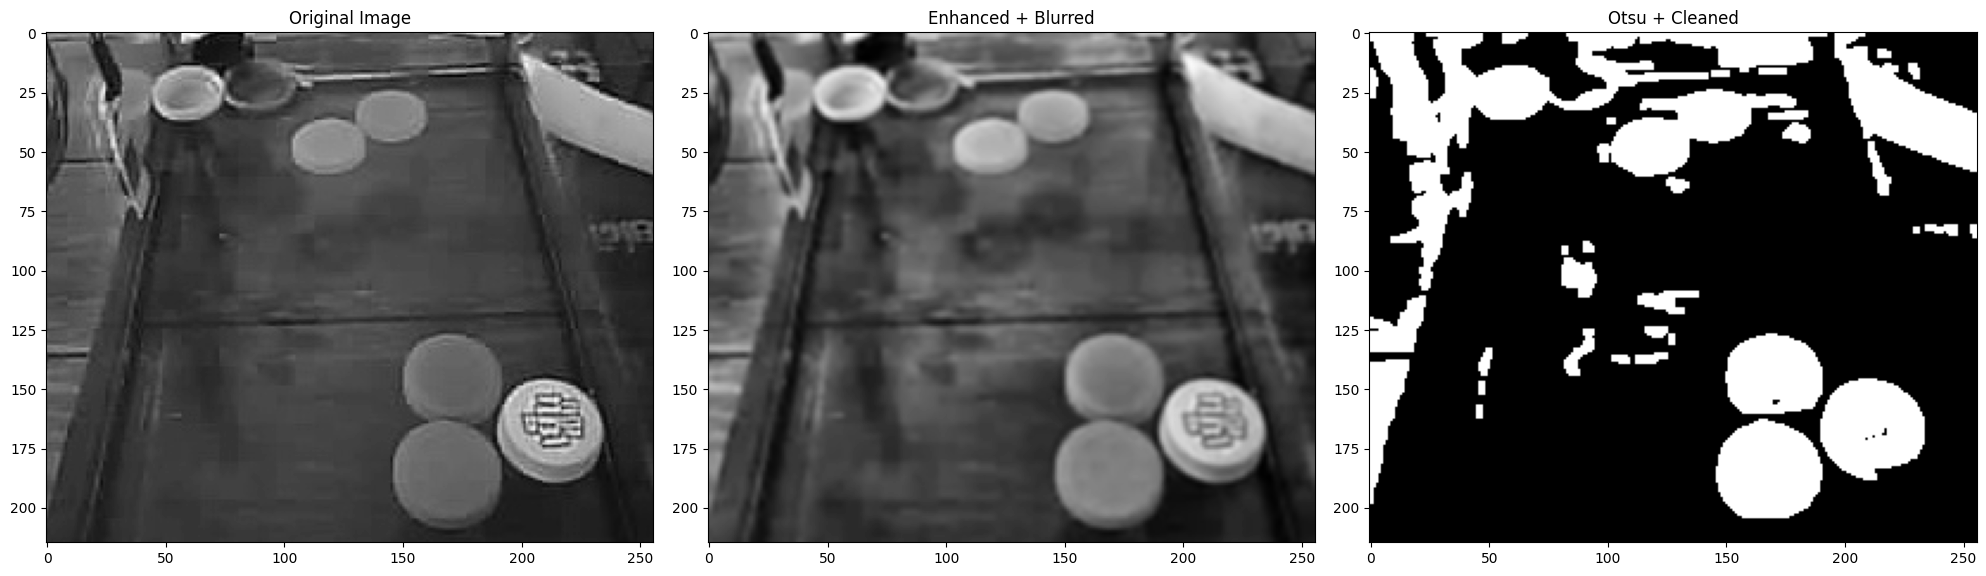

In [9]:
# Example usage
segmented_image = preprocess_and_segment('./cropped/cropped_image.jpg') 

Count Hough Circle Open CV

In [10]:
def count_bottle_caps_with_hough(cleaned_image):
    """
    Count the bottle caps using the Hough Circle Transform on the cleaned binary image.
    """
    color_image = cv2.cvtColor(cleaned_image, cv2.COLOR_GRAY2BGR)  # Convert to color image for visualization
    # Apply Hough Circle Transform to detect circles (bottle caps)
    circles = cv2.HoughCircles(
        cleaned_image,  # Use the cleaned image (binary image)
        cv2.HOUGH_GRADIENT,  # Use the gradient method for detecting circles
        dp=1,  # Resolution of the accumulator array
        minDist=20,  # Minimum distance between the centers of detected circles
        param1=50,  # Higher threshold for the Canny edge detector
        param2=30,  # Threshold for center detection
    )

    # Check if circles are detected
    if circles is not None:
        # Convert (x, y, radius) values to integers
        circles = np.round(circles[0, :]).astype("int")

        # Print the number of bottle caps detected
        print(f"Number of bottle caps detected: {len(circles)}")
        
        for (x, y, r) in circles:
            cv2.circle(color_image, (x, y), r, (0, 255, 0), 4)  # Green circle
            cv2.rectangle(color_image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)  # Orange rectangle
        
        # Display the result with circles drawn
        plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
        plt.title("Detected Bottle Caps")
        plt.show()

        return len(circles)  # Return the number of detected circles (bottle caps)
    else:
        print("No circles detected.")
        return 0  # No bottle caps detected


Number of bottle caps detected: 3


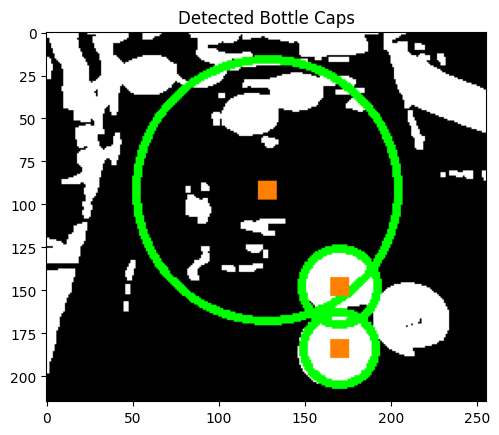

3

In [11]:
count_bottle_caps_with_hough(segmented_image)

Manually pin four corner of the image using open cv to know coordinate
This will help you know coordinate of your image using in next step Segment image

In [ ]:
import cv2 
import numpy as np

corners = []

def mouse_click(event, x, y, flags, param):
  if event == cv2.EVENT_LBUTTONDOWN:
    corners.append([x,y])
    cv2.circle(image, (x,y), 5, (0,255,0), -1)
    cv2.imshow('image', image)

# Load the image
path_image = r'./new/20241129150317.jpg' # Replace with image path
image = cv2.imread(path_image)
clone = image.copy()

# Display the image and set the mouse callback function
cv2.imshow('image', image)  
cv2.setMouseCallback('image', mouse_click)

# Wait for the user to click on the four corners of the document
while len(corners) < 4:
  cv2.waitKey(1)

cv2.destroyAllWindows()

# Sort the corners to get the top-left, top-right, bottom-right, and bottom-left
corners = sorted(corners, key=lambda x: (x[1], x[0]))
print(f'here is coordinate:{corners}')

# Get the bounding box coordinates
x_min = min(corners, key=lambda x: x[0])[0]
x_max = max(corners, key=lambda x: x[0])[0]
y_min = min(corners, key=lambda x: x[1])[1]
y_max = max(corners, key=lambda x: x[1])[1]

# Crop the image using the bounding box coordinates
cropped_image = clone[y_min:y_max, x_min:x_max]

# Display the cropped image
cv2.imshow('Cropped Image', cropped_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


This is class for get the segment image to use in next step DBSCAN

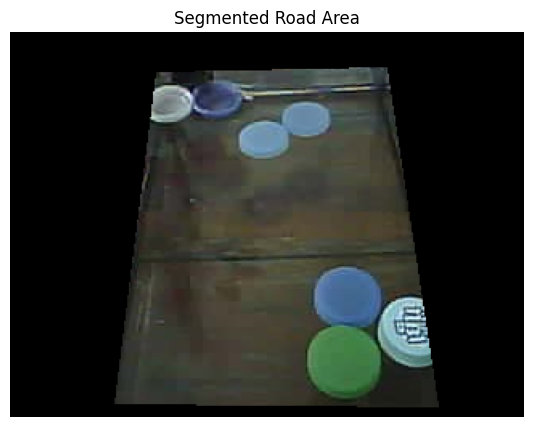

In [12]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

class AreaSegmentor:
    def __init__(self, image):
        self.image = image
        self.gray_image = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        self.coordinates = [(234, 22), (91, 25), (65, 231), (266, 233)]

    def segment_road(self) -> np.ndarray:
        """Segments the road area based on the predefined coordinates."""
        if self.coordinates:
            points = np.array(self.coordinates, dtype=np.int32)
            points = points.reshape((-1, 1, 2)) 
            mask = np.zeros_like(self.gray_image)
            cv.fillPoly(mask, [points], 255)

            segment = cv.bitwise_and(self.image, self.image, mask=mask)
            return segment
        else:
            raise ValueError("No coordinates selected for segmentation.")
        
    def display_segmented_road(self):
        """Displays the segmented road area."""
        segment = self.segment_road()
        plt.figure(figsize=(10, 5))
        plt.imshow(cv.cvtColor(segment, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Segmented Road Area")
        plt.show()

# Usage example
image = cv.imread('./new/20241129150317.jpg')  # Load the image
area_segmentor = AreaSegmentor(image)
area_segmentor.display_segmented_road()

Using DBScan 

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def count_blue_bottle_caps(image_input, eps=6, min_samples=100, lower_blue=(100, 50, 50), upper_blue=(130, 255, 255)):
    """
    Apply DBSCAN clustering to count the number of blue bottle caps by clustering blue pixels in the image.
    
    Args:
    - image_path: Path to the input image.
    - eps: Maximum distance between two samples for them to be considered in the same cluster.
    - min_samples: Minimum number of samples in a neighborhood to form a cluster.
    - lower_blue: Lower bound of the blue color in HSV (H, S, V).
    - upper_blue: Upper bound of the blue color in HSV (H, S, V).
    
    Returns:
    - num_blue_bottle_caps: The number of detected blue bottle caps (clusters).
    """
    # Load the image
    image = image_input
    
    # Convert the image to HSV color space use for Color-based segmentation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Create a mask for blue color
    # by doing this blue will be white(1) as other colors will be black(0)
    mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
    
    # Find the coordinates of non-black pixels (blue regions)
    blue_pixels = np.where(mask > 0)  # Get indices of non-black pixels (blue regions)
    
    # Extract coordinates of non-black pixels
    coords = np.column_stack(blue_pixels)  # Combine row and column into coordinates
    
    # Apply DBSCAN clustering on the coordinates of blue pixels
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(coords)
    
    # Count the number of unique clusters (excluding noise)
    unique_labels = set(labels)
    num_blue_bottle_caps = len([label for label in unique_labels if label != -1])  # Exclude noise (-1)
    
    # Optional: Visualize the clusters
    plt.imshow(mask, cmap='gray')
    plt.scatter(coords[:, 1], coords[:, 0], c=labels, cmap='tab10', marker='o', s=10)
    plt.title(f"Detected Blue Bottle Caps: {num_blue_bottle_caps}")
    plt.show()
    
    return num_blue_bottle_caps

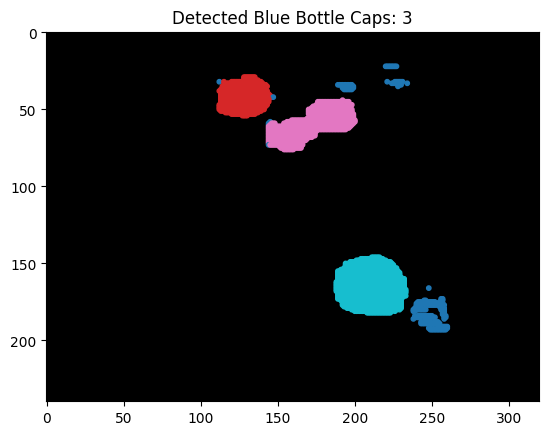

Number of detected blue bottle caps: 3


In [40]:
# Example usage
image = cv.imread('./new/20241129150317.jpg')  # Load the image
area_segmentor = AreaSegmentor(image)
image = area_segmentor.segment_road()  # Segment the road area
num_blue_bottle_caps = count_blue_bottle_caps(image, eps=6, min_samples=100)

print(f"Number of detected blue bottle caps: {num_blue_bottle_caps}")